# Clasificador de Popularidad con Redes Neuronales (MLP) + MLflow

Fecha: 7 de Septiembre, 2025

Descripción
-----------
Reimplementa el experimento previo (XGBoost) con Redes Neuronales Multicapa (MLP) pensadas para datos tabulares.
Mantiene la misma estructura de pasos: carga, split balanceado, búsqueda de hiperparámetros, evaluación Top-3,
visualizaciones, guardado de artefactos y registro en MLflow (local o remoto).


Motivación para usar Redes Neuronales (para datos tabulares)
- Flexibilidad para modelar interacciones no lineales complejas entre features.
- Posibilidad de incorporar en el futuro **embeddings** para variables categóricas de alta cardinalidad
(artista, género, país), y de integrar señales adicionales (texto, imágenes/portadas, etc.).
- Entrenamiento end-to-end con control explícito de regularización (dropout/L2), early stopping y calibración
posterior de probabilidades.


Requisitos sugeridos
- Python 3.10+
- scikit-learn >= 1.2, numpy, pandas, matplotlib, seaborn, joblib, mlflow


Ejecutar el UI de MLflow:
`mlflow ui -p 8050`


Estructura esperada de datos:

`../data/train/X_train.csv`
`../data/train/y_train.csv`


Salida principal
`../models/nn_classifier_results/`

## 1. Librerías necesarias

In [1]:
import os
import json
import math
import warnings
from copy import deepcopy
from dataclasses import dataclass
from datetime import datetime


import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.base import clone
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    precision_recall_curve,
    roc_curve,
    auc,
)


import mlflow
import mlflow.sklearn

Configuraciones de entorno

In [3]:
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)


RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

## 2. Carga de datos

In [8]:
X_train_path = '../data/train/X_train.csv'
y_train_path = '../data/train/y_train.csv'

print("CARGA DE DATOS")
print("=" * 60)
X_train_full = pd.read_csv(X_train_path)
y_train_full = pd.read_csv(y_train_path)
# Si y viene con 1 columna, convertir a Series
if isinstance(y_train_full, pd.DataFrame):
    y_train_full = y_train_full.iloc[:, 0]

# Binarización (>= 30 => 1)
y_train_full = (y_train_full >= 30).astype(int)


print(f"✓ X shape: {X_train_full.shape}")
print(f"✓ y dist:\n{y_train_full.value_counts().sort_index()}")

CARGA DE DATOS
✓ X shape: (91199, 18)
✓ y dist:
popularity
0    40293
1    50906
Name: count, dtype: int64


## 3. Split y validación

In [9]:
print("\nDIVISIÓN TRAIN/VALIDATION (estratificada)")
print("=" * 60)
validation_size = 0.15
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=validation_size, stratify=y_train_full,
    random_state=RANDOM_SEED
)

for name, y in [("Train", y_train), ("Val", y_val)]:
    counts = y.value_counts().sort_index()
    pct0 = 100 * counts.get(0, 0) / len(y)
    pct1 = 100 * counts.get(1, 0) / len(y)
    print(f"{name}: {len(y):,}  |  Clase 0: {pct0:.1f}%  Clase 1: {pct1:.1f}%")



DIVISIÓN TRAIN/VALIDATION (estratificada)
Train: 77,519  |  Clase 0: 44.2%  Clase 1: 55.8%
Val: 13,680  |  Clase 0: 44.2%  Clase 1: 55.8%


## 4. Grilla hiperparámetros

In [10]:
print("\nCONFIGURACIÓN DE PIPELINE Y GRID")
print("=" * 60)

# Imputación (por si acaso), escalado y MLP
pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    ("mlp", MLPClassifier(random_state=RANDOM_SEED, early_stopping=True,
                           n_iter_no_change=10, validation_fraction=0.1,
                           max_iter=200))
])

param_grid = {
    "mlp__hidden_layer_sizes": [
        (64,), (64, 32), (128, 64), (256, 128)
    ],
    "mlp__activation": ["relu", "tanh"],
    "mlp__alpha": [1e-5, 1e-4, 1e-3],
    "mlp__learning_rate_init": [1e-4, 1e-3, 3e-3],
    "mlp__batch_size": [64, 128, 256],
}

print("Parámetros en búsqueda:")
for k, v in param_grid.items():
    print(f"  • {k}: {v}")

cv_folds = 5
print(f"\nValidación cruzada: {cv_folds} folds\n")


CONFIGURACIÓN DE PIPELINE Y GRID
Parámetros en búsqueda:
  • mlp__hidden_layer_sizes: [(64,), (64, 32), (128, 64), (256, 128)]
  • mlp__activation: ['relu', 'tanh']
  • mlp__alpha: [1e-05, 0.0001, 0.001]
  • mlp__learning_rate_init: [0.0001, 0.001, 0.003]
  • mlp__batch_size: [64, 128, 256]

Validación cruzada: 5 folds



## 5. GridSearchCV

In [11]:
print("INICIO GRIDSEARCHCV")
print("=" * 60)
start_time = datetime.now()

gs = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=cv_folds,
    scoring='f1',
    n_jobs=-1,
    verbose=2,
    return_train_score=True,
)

gs.fit(X_train, y_train)
end_time = datetime.now()
duration = end_time - start_time

print("\n✓ GridSearch finalizado")
print(f"Mejores params: {gs.best_params_}")
print(f"Mejor F1 (CV): {gs.best_score_:.6f}")
print(f"Tiempo total: {duration}")

INICIO GRIDSEARCHCV
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[CV] END mlp__activation=relu, mlp__alpha=1e-05, mlp__batch_size=64, mlp__hidden_layer_sizes=(64,), mlp__learning_rate_init=0.0001; total time=   6.6s
[CV] END mlp__activation=relu, mlp__alpha=1e-05, mlp__batch_size=64, mlp__hidden_layer_sizes=(64,), mlp__learning_rate_init=0.001; total time=  14.5s
[CV] END mlp__activation=relu, mlp__alpha=1e-05, mlp__batch_size=64, mlp__hidden_layer_sizes=(64, 32), mlp__learning_rate_init=0.0001; total time=  18.3s
[CV] END mlp__activation=relu, mlp__alpha=1e-05, mlp__batch_size=64, mlp__hidden_layer_sizes=(64, 32), mlp__learning_rate_init=0.003; total time=   9.6s
[CV] END mlp__activation=relu, mlp__alpha=1e-05, mlp__batch_size=64, mlp__hidden_layer_sizes=(128, 64), mlp__learning_rate_init=0.0001; total time=  21.4s
[CV] END mlp__activation=relu, mlp__alpha=1e-05, mlp__batch_size=64, mlp__hidden_layer_sizes=(128, 64), mlp__learning_rate_init=0.001; total time=  20.4s

## 6. Entrenamiento TOP-3

In [13]:
print("\nTOP-3 CONFIGURACIONES (según mean_test_score)")
print("=" * 60)
cv_df = pd.DataFrame(gs.cv_results_).sort_values("mean_test_score", ascending=False)

top3 = cv_df.head(3).copy()
for i, row in enumerate(top3.itertuples(index=False), start=1):
    print(f"Modelo #{i}: F1_CV={row.mean_test_score:.6f} ±{row.std_test_score:.6f} | params={row.params}")

# Entrenar explícitamente los Top-3 en train completo
trained_models = []
trained_params = []
for i, row in enumerate(top3.itertuples(index=False), start=1):
    model_i = clone(pipeline)
    model_i.set_params(**{f"{k}": v for k, v in row.params.items()})
    model_i.fit(X_train, y_train)
    trained_models.append(model_i)
    trained_params.append(row.params)


TOP-3 CONFIGURACIONES (según mean_test_score)
Modelo #1: F1_CV=0.753015 ±0.007751 | params={'mlp__activation': 'relu', 'mlp__alpha': 0.001, 'mlp__batch_size': 256, 'mlp__hidden_layer_sizes': (256, 128), 'mlp__learning_rate_init': 0.001}
Modelo #2: F1_CV=0.751300 ±0.002342 | params={'mlp__activation': 'relu', 'mlp__alpha': 0.0001, 'mlp__batch_size': 64, 'mlp__hidden_layer_sizes': (256, 128), 'mlp__learning_rate_init': 0.001}
Modelo #3: F1_CV=0.751276 ±0.003897 | params={'mlp__activation': 'relu', 'mlp__alpha': 0.0001, 'mlp__batch_size': 256, 'mlp__hidden_layer_sizes': (256, 128), 'mlp__learning_rate_init': 0.001}


## 7. Utilidades

In [14]:
def evaluate_threshold(y_true, y_proba, threshold=0.5):
    y_pred = (y_proba >= threshold).astype(int)
    return {
        'Precision': precision_score(y_true, y_pred, zero_division=0),
        'Recall': recall_score(y_true, y_pred, zero_division=0),
        'F1 Score': f1_score(y_true, y_pred, zero_division=0),
        'Accuracy': accuracy_score(y_true, y_pred),
        'ROC AUC': roc_auc_score(y_true, y_proba)
    }

def find_best_f1_threshold(y_true, y_proba):
    ps, rs, ts = precision_recall_curve(y_true, y_proba)
    # Evitar NaNs en F1
    f1s = np.where((ps + rs) > 0, 2 * ps * rs / (ps + rs), 0.0)
    # precision_recall_curve devuelve thresholds con longitud len(ps)-1
    best_idx = np.argmax(f1s[:-1])
    best_thr = ts[best_idx]
    best_f1 = f1s[best_idx]
    return float(best_thr), float(best_f1)

## 8. Evaluación y validación

In [15]:
print("\nEVALUACIÓN EN CONJUNTO DE VALIDACIÓN")
print("=" * 60)
metrics_results = []
plots_dir = "../models/nn_classifier_results/plots"
results_dir = "../models/nn_classifier_results"
os.makedirs(plots_dir, exist_ok=True)

for i, model in enumerate(trained_models, start=1):
    proba = model.predict_proba(X_val)[:, 1]
    # Umbral por defecto 0.5
    m_default = evaluate_threshold(y_val, proba, threshold=0.5)
    # Umbral óptimo por F1
    best_thr, best_f1 = find_best_f1_threshold(y_val, proba)
    m_best = evaluate_threshold(y_val, proba, threshold=best_thr)

    # Reporte
    y_pred_default = (proba >= 0.5).astype(int)
    report = classification_report(y_val, y_pred_default, target_names=['No Popular', 'Popular'])

    print(f"\nModelo #{i}")
    print("-" * 30)
    print(f"Params: {trained_params[i-1]}")
    print("Métricas (thr=0.5):", {k: round(v, 4) for k, v in m_default.items()})
    print(f"Mejor umbral por F1: {best_thr:.3f} | F1={best_f1:.4f}")
    print("Métricas (thr*=F1):", {k: round(v, 4) for k, v in m_best.items()})
    print("\nReporte de Clasificación (thr=0.5):\n", report)

    # Matriz de confusión (thr=0.5)
    cm = confusion_matrix(y_val, y_pred_default)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Matriz de Confusión - MLP Modelo #{i} (thr=0.5)')
    plt.xlabel('Predicción')
    plt.ylabel('Verdadero')
    cm_path = os.path.join(plots_dir, f'confusion_matrix_model_{i}.png')
    plt.tight_layout(); plt.savefig(cm_path, dpi=140); plt.close()

    # Curva ROC
    fpr, tpr, _ = roc_curve(y_val, proba)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, linewidth=2)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.title(f'Curva ROC - MLP Modelo #{i} (AUC={roc_auc:.3f})')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    roc_path = os.path.join(plots_dir, f'roc_model_{i}.png')
    plt.tight_layout(); plt.savefig(roc_path, dpi=140); plt.close()

    # Curva Precisión-Recall
    ps, rs, ts = precision_recall_curve(y_val, proba)
    pr_auc = auc(rs, ps)
    plt.figure(figsize=(6, 5))
    plt.plot(rs, ps, linewidth=2)
    plt.title(f'Curva Precisión-Recall - MLP Modelo #{i} (AUC={pr_auc:.3f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    pr_path = os.path.join(plots_dir, f'pr_model_{i}.png')
    plt.tight_layout(); plt.savefig(pr_path, dpi=140); plt.close()

    metrics_results.append({
        'Modelo': f'Modelo #{i}',
        'Params': trained_params[i-1],
        'thr_default': 0.5,
        **{f'def_{k}': v for k, v in m_default.items()},
        'thr_best_f1': best_thr,
        **{f'best_{k}': v for k, v in m_best.items()},
        'roc_auc_curve': roc_auc,
        'pr_auc_curve': pr_auc,
        'confusion_matrix_path': cm_path,
        'roc_path': roc_path,
        'pr_path': pr_path,
    })


EVALUACIÓN EN CONJUNTO DE VALIDACIÓN

Modelo #1
------------------------------
Params: {'mlp__activation': 'relu', 'mlp__alpha': 0.001, 'mlp__batch_size': 256, 'mlp__hidden_layer_sizes': (256, 128), 'mlp__learning_rate_init': 0.001}
Métricas (thr=0.5): {'Precision': 0.7074, 'Recall': 0.8134, 'F1 Score': 0.7567, 'Accuracy': 0.708, 'ROC AUC': 0.7693}
Mejor umbral por F1: 0.389 | F1=0.7681
Métricas (thr*=F1): {'Precision': 0.6691, 'Recall': 0.9015, 'F1 Score': 0.7681, 'Accuracy': 0.6961, 'ROC AUC': 0.7693}

Reporte de Clasificación (thr=0.5):
               precision    recall  f1-score   support

  No Popular       0.71      0.57      0.64      6044
     Popular       0.71      0.81      0.76      7636

    accuracy                           0.71     13680
   macro avg       0.71      0.69      0.70     13680
weighted avg       0.71      0.71      0.70     13680


Modelo #2
------------------------------
Params: {'mlp__activation': 'relu', 'mlp__alpha': 0.0001, 'mlp__batch_size': 64, 'm

## 9. Visual Comparativa de Métricas


GRÁFICOS COMPARATIVOS DE MÉTRICAS (thr=0.5)


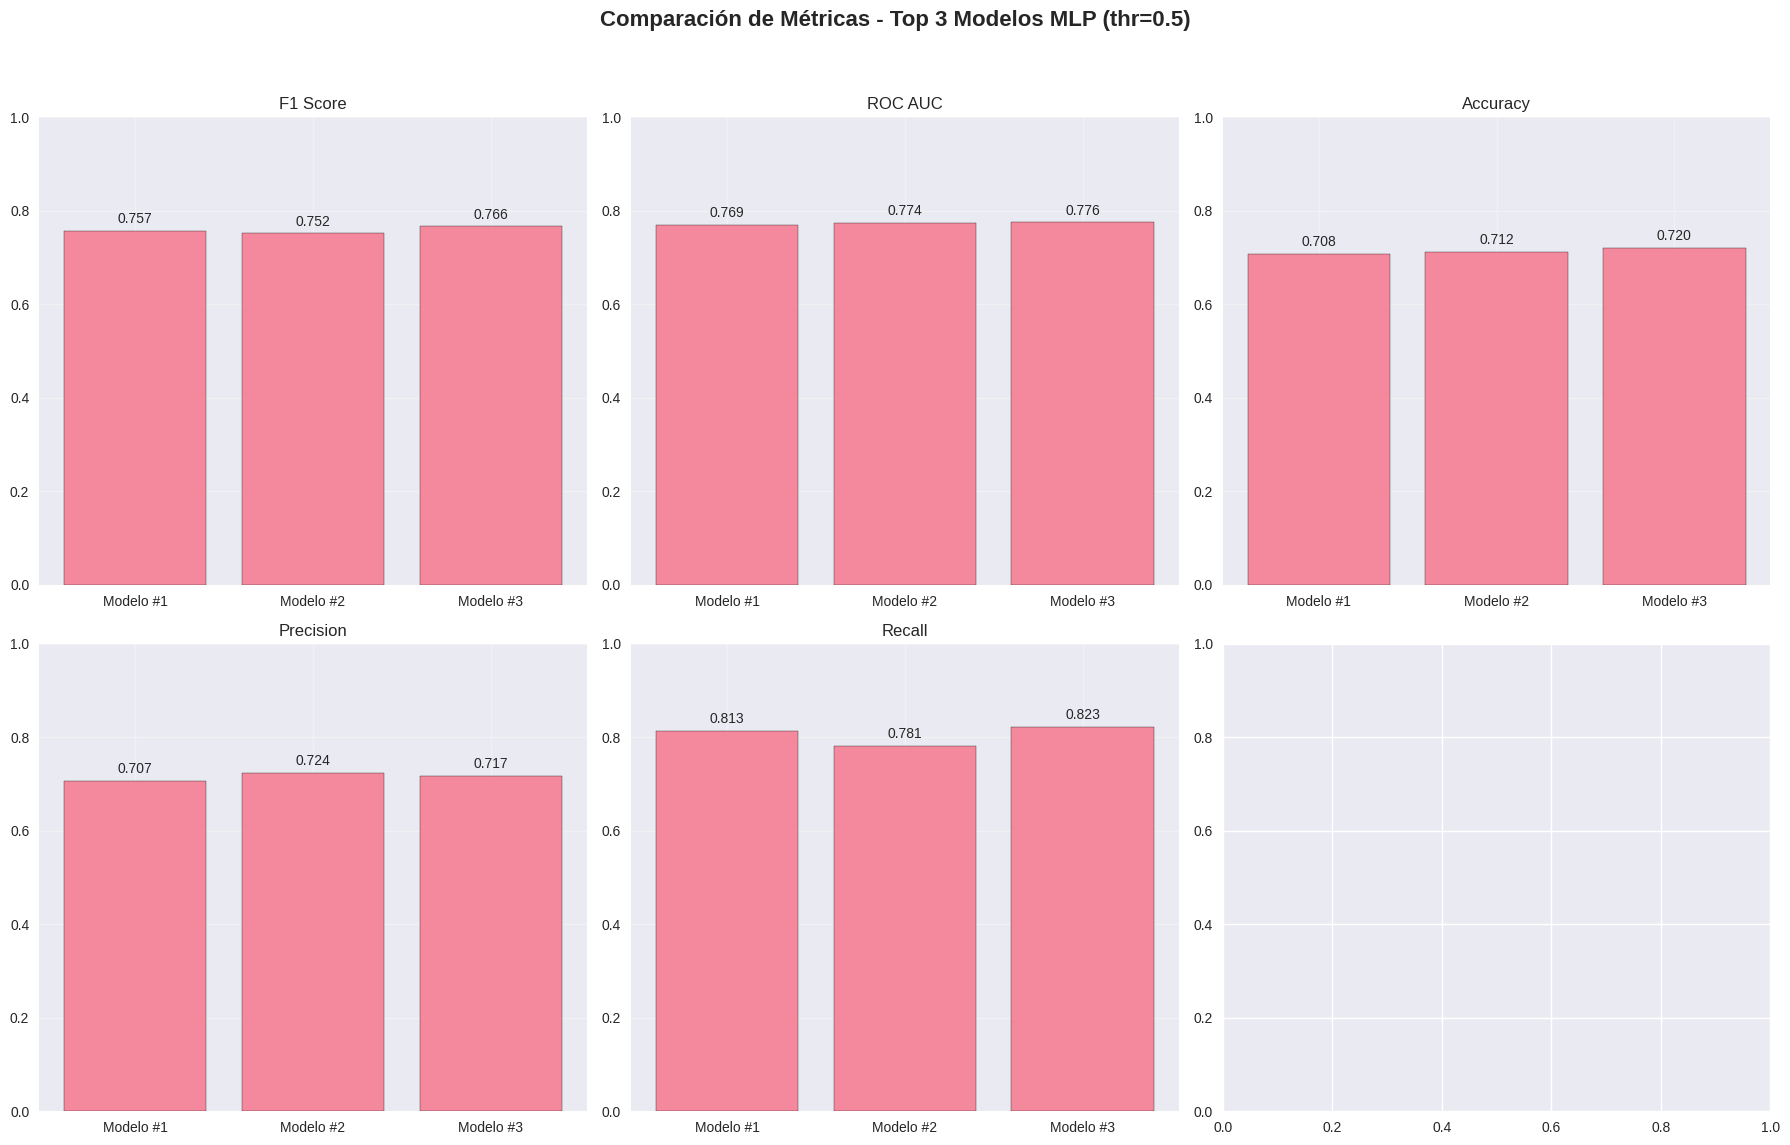


RESUMEN (thr=0.5) — Métricas por modelo
   Modelo  def_F1 Score  def_ROC AUC  def_Accuracy  def_Precision  def_Recall
Modelo #1        0.7567       0.7693        0.7080         0.7074      0.8134
Modelo #2        0.7517       0.7738        0.7119         0.7243      0.7813
Modelo #3        0.7665       0.7757        0.7201         0.7173      0.8229

MEJOR UMBRAL POR F1 — Métricas por modelo
   Modelo  thr_best_f1  best_F1 Score  best_Precision  best_Recall  best_Accuracy  best_ROC AUC
Modelo #1       0.3891         0.7681          0.6691       0.9015         0.6961        0.7693
Modelo #2       0.3078         0.7716          0.6737       0.9027         0.7017        0.7738
Modelo #3       0.3401         0.7734          0.6727       0.9096         0.7025        0.7757


In [26]:
# Tabla de métricas
metrics_df = pd.DataFrame(metrics_results)

# ============================  ============================
print("\nGRÁFICOS COMPARATIVOS DE MÉTRICAS (thr=0.5)")
print("=" * 60)

to_plot = ['def_F1 Score', 'def_ROC AUC', 'def_Accuracy', 'def_Precision', 'def_Recall']
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Comparación de Métricas - Top 3 Modelos MLP (thr=0.5)', fontsize=16, fontweight='bold')

for idx, metric in enumerate(to_plot):
    r = idx // 3; c = idx % 3
    ax = axes[r, c]
    values = metrics_df[metric].values
    models = metrics_df['Modelo'].values
    bars = ax.bar(models, values, alpha=0.8, edgecolor='black')
    ax.set_title(metric.replace('def_', ''))
    ax.set_ylim(0, 1)
    ax.grid(True, alpha=0.3)
    for b, v in zip(bars, values):
        ax.text(b.get_x() + b.get_width()/2., v + 0.01, f"{v:.3f}", ha='center', va='bottom')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
bar_path = os.path.join(plots_dir, 'metrics_barplot.png')
plt.savefig(bar_path, dpi=140);
plt.show()

# ============================ RESUMEN EN TEXTO POR MODELO ============================
print("\nRESUMEN (thr=0.5) — Métricas por modelo")
print("=" * 60)
cols_def = ['Modelo', 'def_F1 Score', 'def_ROC AUC', 'def_Accuracy', 'def_Precision', 'def_Recall']
print(metrics_df[cols_def].round(4).to_string(index=False))

print("\nMEJOR UMBRAL POR F1 — Métricas por modelo")
print("=" * 60)
cols_best = ['Modelo', 'thr_best_f1', 'best_F1 Score', 'best_Precision', 'best_Recall', 'best_Accuracy', 'best_ROC AUC']
print(metrics_df[cols_best].round(4).to_string(index=False))

## 10. Guardado de Modelos y Resultados

In [17]:
print("\nGUARDANDO ARTEFACTOS")
print("=" * 60)

os.makedirs(results_dir, exist_ok=True)

# Guardar Top-3 modelos
model_paths = []
for i, model in enumerate(trained_models, start=1):
    p = os.path.join(results_dir, f'top_{i}_mlp_model.joblib')
    joblib.dump(model, p)
    model_paths.append(p)
    print(f"✓ Modelo #{i} guardado en: {p}")

# Guardar métricas
metrics_csv = os.path.join(results_dir, 'model_metrics_nn.csv')
metrics_df.to_csv(metrics_csv, index=False)
print(f"✓ Métricas guardadas en: {metrics_csv}")

# Resumen de experimento
experiment_summary = {
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'algorithm': 'MLPClassifier (scikit-learn) con Pipeline',
    'dataset_original_registros': int(len(X_train_full)),
    'training_size': int(len(X_train)),
    'validation_size': int(len(X_val)),
    'features_count': int(X_train.shape[1]),
    'cv_folds': int(cv_folds),
    'best_params_cv': gs.best_params_,
    'best_cv_f1': float(gs.best_score_),
    'search_duration': str(duration),
}
summary_path = os.path.join(results_dir, 'experiment_summary_nn.json')
with open(summary_path, 'w') as f:
    json.dump(experiment_summary, f, indent=2)
print(f"✓ Resumen guardado en: {summary_path}")


GUARDANDO ARTEFACTOS
✓ Modelo #1 guardado en: ../models/nn_classifier_results/top_1_mlp_model.joblib
✓ Modelo #2 guardado en: ../models/nn_classifier_results/top_2_mlp_model.joblib
✓ Modelo #3 guardado en: ../models/nn_classifier_results/top_3_mlp_model.joblib
✓ Métricas guardadas en: ../models/nn_classifier_results/model_metrics_nn.csv
✓ Resumen guardado en: ../models/nn_classifier_results/experiment_summary_nn.json


## 11. Registro en MLflow

In [22]:
print("\nREGISTRO EN MLFLOW")
print("=" * 60)

# Tracking: usa MLFLOW_TRACKING_URI si existe; si no, FileStore local (./mlruns)
tracking_uri = os.environ.get("MLFLOW_TRACKING_URI", "file:./mlruns")
mlflow.set_tracking_uri(tracking_uri)
print(f"Tracking URI: {mlflow.get_tracking_uri()}")

# Crea/usa el experimento
experiment = mlflow.set_experiment("MLP_Binary_Classifier_Experiment")

# Intentamos firmar el modelo para evitar warnings de 'signature' y 'input_example'
from mlflow.models import infer_signature

with mlflow.start_run(experiment_id=experiment.experiment_id, run_name="MLP Top3 Validation Metrics"):
    # Artefactos globales del experimento
    mlflow.log_artifact(bar_path, artifact_path="plots")
    mlflow.log_artifact(metrics_csv, artifact_path="artifacts")
    mlflow.log_artifact(summary_path, artifact_path="artifacts")

    # Runs anidados: uno por cada modelo del Top-3
    for model_idx, row in metrics_df.reset_index(drop=True).iterrows():
        with mlflow.start_run(nested=True, run_name=f"Model_{model_idx+1}"):
            params = row["Params"]
            mlflow.log_params({k.replace("mlp__",""): v for k, v in params.items()})

            # Thresholds
            mlflow.log_metric("thr_default", row["thr_default"])
            mlflow.log_metric("thr_best_f1", row["thr_best_f1"])

            # Métricas con thr=0.5
            mlflow.log_metric("def_precision", row["def_Precision"])
            mlflow.log_metric("def_recall",    row["def_Recall"])
            mlflow.log_metric("def_f1",        row["def_F1 Score"])
            mlflow.log_metric("def_accuracy",  row["def_Accuracy"])
            mlflow.log_metric("def_roc_auc",   row["def_ROC AUC"])

            # Métricas con umbral óptimo por F1
            mlflow.log_metric("best_precision", row["best_Precision"])
            mlflow.log_metric("best_recall",    row["best_Recall"])
            mlflow.log_metric("best_f1",        row["best_F1 Score"])
            mlflow.log_metric("best_accuracy",  row["best_Accuracy"])
            mlflow.log_metric("best_roc_auc",   row["best_ROC AUC"])

            # Gráficos por modelo
            mlflow.log_artifact(row["confusion_matrix_path"], artifact_path="plots")
            mlflow.log_artifact(row["roc_path"],              artifact_path="plots")
            mlflow.log_artifact(row["pr_path"],               artifact_path="plots")

            # Firma e input_example para evitar warnings
            sample = X_train.head(5)
            try:
                signature = infer_signature(sample, trained_models[model_idx].predict_proba(sample))
            except Exception:
                signature = None

            # Registrar el pipeline sklearn
            # MLflow >= 2.14 recomienda 'name='; si tu versión no lo soporta, hace fallback a 'artifact_path='
            try:
                mlflow.sklearn.log_model(
                    sk_model=trained_models[model_idx],
                    name=f"model_{model_idx+1}_sklearn_pipeline",
                    signature=signature,
                    input_example=sample,
                )
            except TypeError:
                mlflow.sklearn.log_model(
                    sk_model=trained_models[model_idx],
                    artifact_path=f"model_{model_idx+1}_sklearn_pipeline",
                    signature=signature,
                    input_example=sample,
                )

print("✓ Métricas y modelos registrados en MLflow")

2025/09/07 13:03:36 INFO mlflow.tracking.fluent: Experiment with name 'MLP_Binary_Classifier_Experiment' does not exist. Creating a new experiment.



REGISTRO EN MLFLOW
Tracking URI: http://127.0.0.1:8050
🏃 View run Model_1 at: http://127.0.0.1:8050/#/experiments/347449219307071451/runs/01e9d60784b64a3e8fb6c95db9dd0fa6
🧪 View experiment at: http://127.0.0.1:8050/#/experiments/347449219307071451
🏃 View run Model_2 at: http://127.0.0.1:8050/#/experiments/347449219307071451/runs/c7c8b301f72b446c905922c9afbf2de8
🧪 View experiment at: http://127.0.0.1:8050/#/experiments/347449219307071451
🏃 View run Model_3 at: http://127.0.0.1:8050/#/experiments/347449219307071451/runs/aec01118f66f4252b409da4a6682e50a
🧪 View experiment at: http://127.0.0.1:8050/#/experiments/347449219307071451
🏃 View run MLP Top3 Validation Metrics at: http://127.0.0.1:8050/#/experiments/347449219307071451/runs/bc6334e8b6d14dd4a54f01236a19f9eb
🧪 View experiment at: http://127.0.0.1:8050/#/experiments/347449219307071451
✓ Métricas y modelos registrados en MLflow


## 12. Resumen Final

In [27]:
print("\n🎉 EXPERIMENTO COMPLETADO (MLP)")
print("=" * 60)
print(f"Dataset original: {len(X_train_full):,} registros | Features: {X_train.shape[1]}")
print(f"Train: {len(X_train):,}  |  Val: {len(X_val):,}")
print(f"Mejor F1 (CV): {gs.best_score_:.4f}")
print("\nTop-3 (thr=0.5)")
print(metrics_df[[
    'Modelo', 'def_F1 Score', 'def_ROC AUC', 'def_Accuracy', 'def_Precision', 'def_Recall', 'thr_best_f1', 'best_F1 Score'
]].to_string(index=False))
print("\nArtefactos:")
print(f"  • Modelos: {model_paths}")
print(f"  • Métricas CSV: {metrics_csv}")
print(f"  • Resumen JSON: {summary_path}")
print(f"  • Plots: {plots_dir}")
print("\nSugerencias:")
print("  • Si deseas mejorar calibración de probabilidades, aplica CalibratedClassifierCV sobre el pipeline con 'sigmoid'.")
print("  • Considera ingeniería de features (interacciones, log/box-cox) y/o incluir embeddings para categorías de alta cardinalidad.")


🎉 EXPERIMENTO COMPLETADO (MLP)
Dataset original: 91,199 registros | Features: 18
Train: 77,519  |  Val: 13,680
Mejor F1 (CV): 0.7530

Top-3 (thr=0.5)
   Modelo  def_F1 Score  def_ROC AUC  def_Accuracy  def_Precision  def_Recall  thr_best_f1  best_F1 Score
Modelo #1      0.756701     0.769339      0.708041       0.707403    0.813384     0.389142       0.768089
Modelo #2      0.751717     0.773757      0.711915       0.724293    0.781299     0.307788       0.771590
Modelo #3      0.766482     0.775705      0.720102       0.717270    0.822944     0.340124       0.773411

Artefactos:
  • Modelos: ['../models/nn_classifier_results/top_1_mlp_model.joblib', '../models/nn_classifier_results/top_2_mlp_model.joblib', '../models/nn_classifier_results/top_3_mlp_model.joblib']
  • Métricas CSV: ../models/nn_classifier_results/model_metrics_nn.csv
  • Resumen JSON: ../models/nn_classifier_results/experiment_summary_nn.json
  • Plots: ../models/nn_classifier_results/plots

Sugerencias:
  • Si deseas